In [1]:
import os, json, pickle, time, random, copy
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from scipy import spatial

# Useful Functions

In [2]:
def get_coords(nw_df):
    node_to_lon_lat = {}
    link_to_lon_lat = {}
    for idx, row in nw_df.iterrows():
        if str(row['aNodes']) not in node_to_lon_lat:
            node_to_lon_lat[str(row['aNodes'])] = (row['aNodeLon'], row['aNodeLat'])
        if str(row['bNodes']) not in node_to_lon_lat:
            node_to_lon_lat[str(row['bNodes'])] = (row['bNodeLon'], row['bNodeLat'])
        link_to_lon_lat[row['aNode_bNode']] = {
            'from_coord': (row['aNodeLon'], row['aNodeLat']),
            'to_coord': (row['bNodeLon'], row['bNodeLat'])
        }
    return node_to_lon_lat, link_to_lon_lat

def get_link_collection(link_to_lon_lat):
    links = [(link['from_coord'], link['to_coord']) 
             for name, link in link_to_lon_lat.items()]
    links_collection = matplotlib.collections.LineCollection(links, colors='grey')
    return links_collection


def build_kd_tree(node_to_lon_lat):
    node_idx = list(node_to_lon_lat.keys())
    node_coords = list(node_to_lon_lat.values())
    nodes_kdtree=spatial.KDTree(np.array(node_coords))
    return nodes_kdtree, node_idx

def get_shortest_route_given_nodes(from_nodes, to_nodes, nw):
    for fn in from_nodes:
        for tn in to_nodes:
            if fn == tn:
                return []
            else:
                try: 
                    node_path = nx.shortest_path(nw, fn, tn, 
                                                 method='dijkstra', 
                                                 weight='weight')
                    return node_path
                except Exception as e:
                    pass
    return None

def get_shortest_route_given_coords(nw, from_coord, to_coord, 
                                    nodes_kdtree, node_idx):
    from_nodes = [node_idx[idx] for idx in nodes_kdtree.query(from_coord, 5)[1]]
    to_nodes = [node_idx[idx] for idx in nodes_kdtree.query(to_coord, 5)[1]]
    route = get_shortest_route_given_nodes(from_nodes, to_nodes, nw)
    return route
    

def viz_transportation_network(link_to_lon_lat, fig=None, ax=None):
    if not fig:
        fig = plt.figure(figsize=(16,12))
    if not ax:
        ax = fig.add_subplot(111)
    links_collection = get_link_collection(link_to_lon_lat)
    ax.add_collection(links_collection)
    ax.axis('off')
    ax.axis('equal')
    return ax, fig

def viz_path(from_coord, to_coord, route, node_to_lon_lat, fig=None, ax=None):
    if not fig:
        fig = plt.figure(figsize=(16,12))
    if not ax:
        ax = fig.add_subplot(111)
    ori, = ax.plot(from_coord[0], from_coord[1], 'b>', 
                   label='origin', markersize=15)
    des, = ax.plot(to_coord[0], to_coord[1], 'g^', label='destination', 
                   markersize=15)
   
    if route is not None and len(route) > 0:
        lon = np.array([(node_to_lon_lat[route[i]][0], node_to_lon_lat[route[i+1]][0]) 
                       for i in range(len(route)-1)]).transpose()
        lat = np.array([(node_to_lon_lat[route[i]][1], node_to_lon_lat[route[i+1]][1]) 
                       for i in range(len(route)-1)]).transpose()
        r = ax.plot(lon, lat, '-', color='red', linewidth=3)
    ax.axis('off')
    ax.axis('equal')
    ax.legend()
   

# Network Data

In [3]:
os.chdir('D:/L3/L3_SZ_CityScope/backend')
grids = json.load(open('cities/shenzhen/geojson/grid1_4326.geojson', 'r'))['features']
positions = [tuple(np.array(g['geometry']['coordinates'][0][:4]).mean(axis=0)) 
             for g in grids]

nw_path = 'cities/shenzhen/clean/sim_network.p'
nw_df_path = 'cities/shenzhen/clean/sim_net_df.csv'

nw = pickle.load(open(nw_path, 'rb'))
nw_df = pd.read_csv(nw_df_path)
nw_df.head()

,aNode_bNode,aNodes,bNodes,aNodeLat,aNodeLon,bNodeLat,bNodeLon,type,name,speed,ref,osmid,oneway,distance,activity,minutes
0,5832657762_5832657763,5832657762,5832657763,22.542695,114.050581,22.542728,114.050515,primary_link,[],[],[],25421053,yes,7.761890,driving,0.015530
1,5832657763_499543448,5832657763,499543448,22.542728,114.050515,22.542747,114.050455,primary_link,[],[],[],25421053,yes,6.526336,driving,0.013058
2,499543448_7961465926,499543448,7961465926,22.542747,114.050455,22.542775,114.050385,primary_link,[],[],[],25421053,yes,7.834173,driving,0.015675
3,7961465926_499543451,7961465926,499543451,22.542775,114.050385,22.542807,114.050310,primary_link,[],[],[],25421053,yes,8.526816,driving,0.017060
4,499543451_7961465925,499543451,7961465925,22.542807,114.050310,22.543073,114.049877,primary_link,[],[],[],25421053,yes,53.312559,driving,0.106668


In [4]:
node_to_lon_lat, link_to_lon_lat = get_coords(nw_df)
nodes_kdtree, node_idx = build_kd_tree(node_to_lon_lat)

# Check Shortest Route

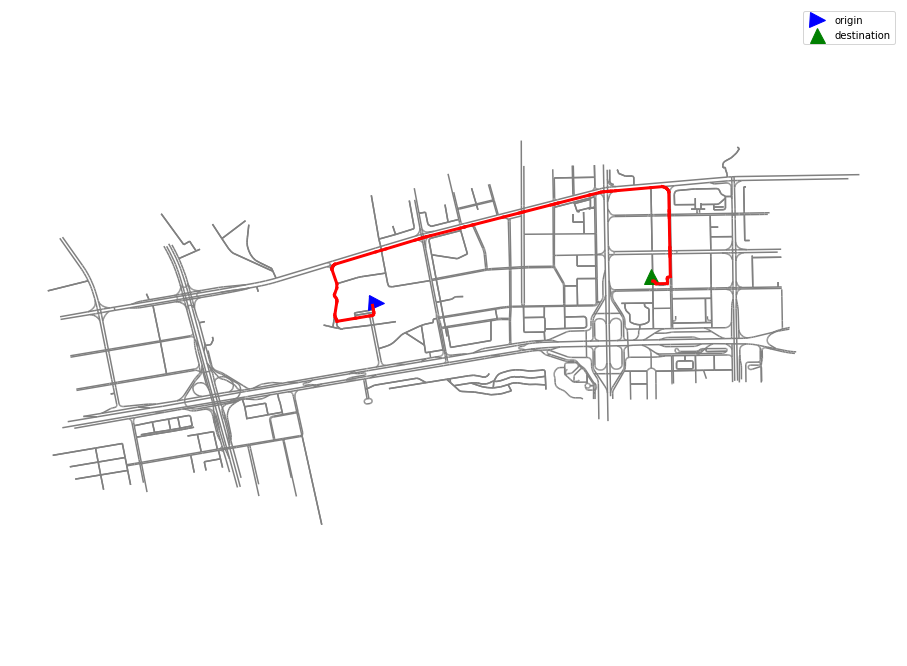

In [5]:
# %matplotlib qt
%matplotlib inline
from_coord = random.choice(positions)
to_coord = random.choice(positions)
while to_coord == from_coord:
    to_coord = random.choice(positions)
    
route = get_shortest_route_given_coords(nw, from_coord, to_coord, 
                                        nodes_kdtree, node_idx)
# print(f'Shortest route from {from_coord} to {to_coord} is:\n{route}')

ax, fig = viz_transportation_network(link_to_lon_lat)
_ = viz_path(from_coord, to_coord, route, node_to_lon_lat, fig, ax)

# Modify the Network

In [6]:
nw2 = nw.copy()

"""
Modify the network 
"""

from_coord = random.choice(positions)
to_coord = random.choice(positions)
while to_coord == from_coord:
    to_coord = random.choice(positions)

origin_node = str(node_idx[nodes_kdtree.query(from_coord)[1]])
destination_node = str(node_idx[nodes_kdtree.query(to_coord)[1]])

nw2.add_edge(origin_node, destination_node, weight=0.0001)
nw2.add_edge(destination_node, origin_node, weight=0.0001)

# Comparing

Shortest Path
 from (114.03289656477881, 22.54832976109091)
 to (114.04590236788296, 22.546962437047576)


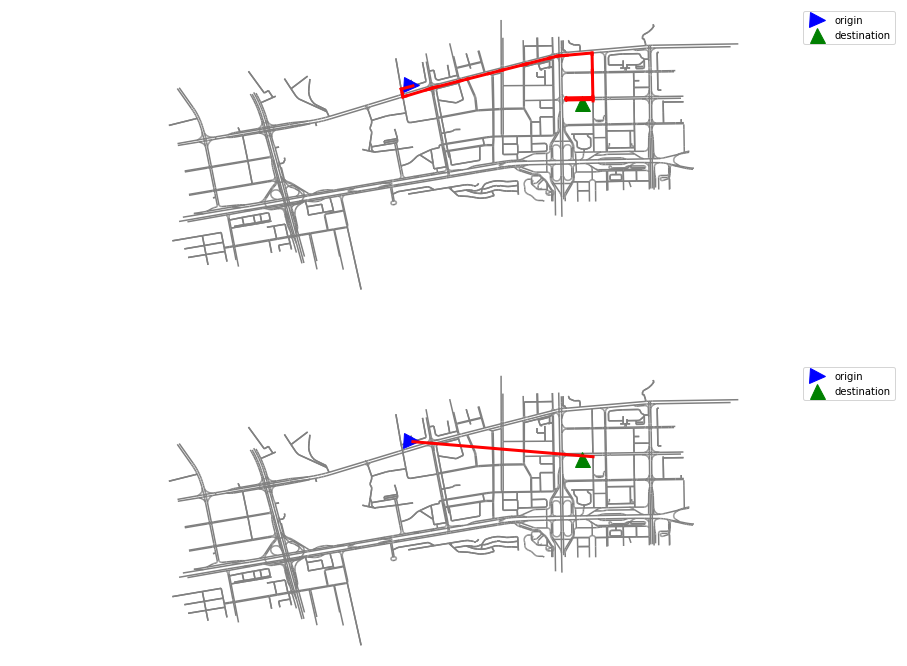

In [7]:
# %matplotlib qt
%matplotlib inline
    
route1 = get_shortest_route_given_coords(nw, from_coord, to_coord, 
                                         nodes_kdtree, node_idx)
route2 = get_shortest_route_given_coords(nw2, from_coord, to_coord, 
                                         nodes_kdtree, node_idx)
# print(f'Shortest route from {from_coord} to {to_coord} is:\n{route}')

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,12))
print(f'Shortest Path\n from {from_coord}\n to {to_coord}')
# plt.suptitle(f'Shortest Path\n from {from_coord}\n to {to_coord}', fontsize=15)

ax1, fig = viz_transportation_network(link_to_lon_lat, fig, ax1)
_ = viz_path(from_coord, to_coord, route1, node_to_lon_lat, fig, ax1)

ax1, fig = viz_transportation_network(link_to_lon_lat, fig, ax2)
_ = viz_path(from_coord, to_coord, route2, node_to_lon_lat, fig, ax2)